<a href="https://colab.research.google.com/github/Nafi-ruet-ece/Pneumonia_detection_using_X-ray/blob/main/chestxrayusingvgggfinalthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmadnafi58","key":"0770112b7b79449dd67e6a4e4ff85d30"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:43<00:00, 22.5MB/s]
100% 2.29G/2.29G [01:43<00:00, 23.8MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/chest-xray-pneumonia.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# data processing, CSV & image file I/O
import os
import re
import requests
from PIL import Image
import pandas as pd
import numpy as np

#libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#preprocessing, modeling & Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
main_path='/content/chest_xray'
os.listdir(main_path)

['test', 'train', '__MACOSX', 'val', 'chest_xray']

In [ ]:
train_dir = os.path.join(main_path, 'train')
val_dir = os.path.join(main_path, 'val')
test_dir = os.path.join(main_path, 'test')

In [ ]:
def count_file(dir=None, labels=None):
  for label in labels:
    num_data= len(os.listdir(os.path.join(dir, label)))
    print(f'number of {label} : {num_data}')

labels= ['PNEUMONIA','NORMAL']
print('Train Set: \n' + '='*50)
count_file(train_dir,labels)

print('\nValidation Set: \n' + '='*50)
count_file(val_dir,labels)

print('\nTest Set: \n' + '='*50)
count_file(test_dir,labels)

Train Set: 
number of PNEUMONIA : 3875
number of NORMAL : 1341

Validation Set: 
number of PNEUMONIA : 8
number of NORMAL : 8

Test Set: 
number of PNEUMONIA : 390
number of NORMAL : 234


In [ ]:
def get_file_sizes(directory):
    file_sizes = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            size = os.path.getsize(file_path) / 1024 #bytes to KB
            file_sizes.append({'file': file_path, 'size_kb': round(size,3)})
    return file_sizes

In [ ]:
get_file_sizes(train_dir)[:5]

[{'file': '/content/chest_xray/train/NORMAL/NORMAL2-IM-0667-0001.jpeg',
  'size_kb': 455.934},
 {'file': '/content/chest_xray/train/NORMAL/IM-0257-0001.jpeg',
  'size_kb': 513.956},
 {'file': '/content/chest_xray/train/NORMAL/IM-0388-0001.jpeg',
  'size_kb': 550.497},
 {'file': '/content/chest_xray/train/NORMAL/IM-0617-0001.jpeg',
  'size_kb': 498.627},
 {'file': '/content/chest_xray/train/NORMAL/IM-0535-0001.jpeg',
  'size_kb': 487.073}]

In [ ]:
def create_dataframe(path=None, labels=None):
    data = []
    for label in labels:
        category_path = os.path.join(path, label)
        file_sizes = get_file_sizes(category_path)
        data.extend(file_sizes)

    df = pd.DataFrame(data)
    return df

In [ ]:
train_df = create_dataframe(train_dir, labels)
test_df = create_dataframe(test_dir, labels)
val_df = create_dataframe(val_dir, labels)

print('shape of train_dir',train_df.shape)
print('shape of test_dir',test_df.shape)
print('shape of val_dir',val_df.shape)

shape of train_dir (5216, 2)
shape of test_dir (624, 2)
shape of val_dir (16, 2)


In [ ]:
train_df.head(3)

,file,size_kb
0,/content/chest_xray/train/PNEUMONIA/person1176...,44.096
1,/content/chest_xray/train/PNEUMONIA/person1082...,75.992
2,/content/chest_xray/train/PNEUMONIA/person584_...,68.713


In [ ]:
def extract_label(file_path):
    if 'PNEUMONIA' in file_path:
        return 'pneumonia'
    elif 'NORMAL' in file_path:
        return 'normal'
    else:
        return 'unknown'

dict_dir_df = {'train': train_df,
               'val': val_df,
               'test': test_df}

In [ ]:
for df in dict_dir_df.values():
    df['label'] = df['file'].apply(extract_label)

In [ ]:
train_df.sample(3)

,file,size_kb,label
1897,/content/chest_xray/train/PNEUMONIA/person1360...,162.746,pneumonia
877,/content/chest_xray/train/PNEUMONIA/person363_...,166.385,pneumonia
4503,/content/chest_xray/train/NORMAL/NORMAL2-IM-11...,788.839,normal


In [ ]:
def get_image_dimensions(file_path):
    try:
        with Image.open(file_path) as img:
            return img.size
    except Exception as e:
        print(f"Error reading image {file_path}: {e}")
        return (0, 0)

In [ ]:
for name, df in dict_dir_df.items():
    df['dimensions'] = df['file'].apply(get_image_dimensions)

In [ ]:
for name, df in dict_dir_df.items():
    filtered_dir = df[df['dimensions'].apply(lambda x: len(x) >= 3)]
    print(f'{name}:',filtered_dir.shape[0])

train: 0
val: 0
test: 0


In [ ]:
print('shape of train_dir',train_df.shape)
print('shape of test_dir',test_df.shape)
print('shape of val_dir',val_df.shape)

shape of train_dir (5216, 4)
shape of test_dir (624, 4)
shape of val_dir (16, 4)


In [ ]:
merged_df = pd.concat([train_df, val_df,test_df], ignore_index=True)
merged_df.shape

(5856, 4)

In [ ]:
train_df, test_df_full = train_test_split(merged_df, test_size=0.3,
                                    stratify = merged_df['label'], random_state=42)

test_df, val_df = train_test_split(test_df_full, test_size=0.5,
                                    stratify = test_df_full['label'], random_state=42)

In [ ]:
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(4099, 4)
(878, 4)
(879, 4)


In [ ]:
def preprocess_image(file_path, label, channels=3):

    img = tf.io.read_file(file_path)


    img = tf.image.decode_jpeg(img, channels=channels)


    img = tf.image.resize(img, [224, 224])


    img = tf.cast(img, tf.float32) / 255.0


    label = tf.where(tf.math.equal(label, 'normal'), 0, 1)


    return img, label

In [ ]:
def color_jitter(image, brightness_factor=0.01, contrast_factor=0.01, seed=None):
    image = tf.image.random_brightness(image, max_delta=0.1, seed=seed)
    image = tf.image.random_contrast(image, lower=1-contrast_factor, upper=1+contrast_factor, seed=seed)
    image = tf.image.random_saturation(image, lower=1-contrast_factor, upper=1+contrast_factor, seed=seed)
    image = tf.image.random_hue(image, max_delta=0.1, seed=seed)

    return image

In [ ]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

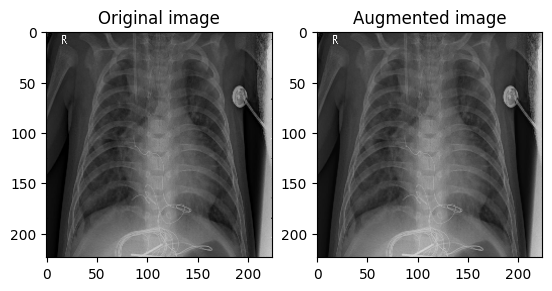

In [ ]:
image_path = '/content/chest_xray/train/PNEUMONIA/person1180_virus_2010.jpeg'
img, label = preprocess_image(image_path,'pneumonia',channels=3)
color_jiter_test = color_jitter(img,seed=3)
visualize(img, color_jiter_test)

In [ ]:
img.shape

TensorShape([224, 224, 3])

In [ ]:
number = train_df.shape[0]
factors = []


for i in range(1, number + 1):
    if number % i == 0:
        factors.append(i)


print("factor to factor distribution", number, "is:", factors)

factor to factor distribution 4099 is: [1, 4099]


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE


batch_size = 32

In [ ]:
def augment_train_image(img, label):

    #img = tf.image.random_flip_left_right(img)
    #img = tf.image.random_flip_up_down(img)
    img= color_jitter(img, seed=3)
    return img, label


def augment_val_image(img, label):

    return img, label

layers_augmentation = tf.keras.Sequential([
            #tf.keras.layers.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.RandomRotation(0.02),
            tf.keras.layers.RandomZoom(height_factor=(0.05, 0.1),width_factor=(0.05, 0.1)),
        ])

In [ ]:
def prepare(ds, batch_size=32,shuffle=False, layers_aug=False, custom_aug=False):

    ds = ds.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.cache()

    if shuffle:
        ds = ds.shuffle(buffer_size=1000)


    if custom_aug:
        ds = ds.map(augment_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if layers_aug:
        ds = ds.map(lambda x, y: (layers_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

    ds = ds.batch(batch_size)
    ds = ds.prefetch(AUTOTUNE)

    return ds

In [ ]:
train_image_paths = train_df['file'].values
train_labels = train_df['label'].values

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))

train_ds= prepare(train_dataset, batch_size, shuffle=False, custom_aug=True)


val_dataset = tf.data.Dataset.from_tensor_slices((val_df['file'].values, val_df['label'].values))
val_ds = prepare(val_dataset,batch_size, shuffle=False)

test_dataset = tf.data.Dataset.from_tensor_slices((test_df['file'].values, test_df['label'].values))
test_ds = prepare(test_dataset, batch_size, shuffle=False)

In [ ]:
for images, labels in train_ds.take(1):
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch Size: {images.shape[0]}")
    print(f"Labels: {labels}")

Batch of images shape: (32, 224, 224, 3)
Batch Size: 32
Labels: [1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1]


In [ ]:
for images, labels in train_ds.take(1):
    print(images[0,:,:,0])

tf.Tensor(
[[0.8690091  0.8562138  0.84833395 ... 0.08205068 0.0984824  0.11285731]
 [0.85540116 0.8494826  0.8759961  ... 0.07414076 0.09054735 0.0989086 ]
 [0.8892578  0.91616255 0.9084784  ... 0.07537466 0.0692704  0.09665659]
 ...
 [0.11287779 0.11287779 0.11287779 ... 0.11681017 0.11681017 0.11681017]
 [0.11681017 0.11681017 0.11287779 ... 0.11681017 0.11681017 0.11681017]
 [0.11681017 0.11681017 0.11287779 ... 0.11681017 0.11681017 0.11681017]], shape=(224, 224), dtype=float32)


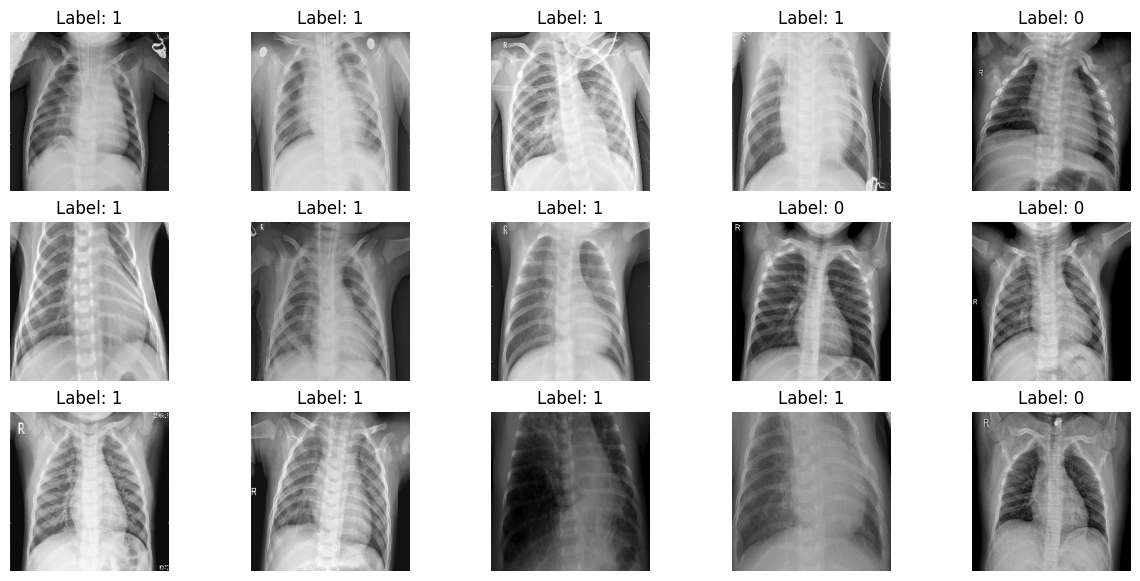

In [ ]:
for images, labels in train_ds.take(1):

    plt.figure(figsize=(15, 7))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis('off')
    plt.show()

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D

In [ ]:
#  model VGG16 pre-trained
input_shape= (224, 224, 3)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
model_4 = tf.keras.Sequential()
model_4.add(base_model)
#model_4.add(GlobalAveragePooling2D())
model_4.add(Flatten())
model_4.add(Dense(198, activation='relu'))
model_4.add(Dense(128, activation='relu'))
model_4.add(Dropout(0.2))
model_4.add(Dense(1, activation='sigmoid'))

for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
model_4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 198)               4967622   
                                                                 
 dense_1 (Dense)             (None, 128)               25472     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 19707911 (75.18 MB)
Trainable params: 49

In [ ]:
#  learning rate
learning_rate = 0.01  # dafault 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_4.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint_filepath4 = '/tmp/checkpoint4'
checkpoint_dir4 = os.path.dirname(checkpoint_filepath4)

callbacks_1 = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_filepath4, monitor='val_loss',mode='min',
                    save_weights_only=True, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)
]

In [ ]:
history_4= model_4.fit(train_ds, validation_data=val_ds,
            epochs=200,
            callbacks=callbacks_1, verbose=1)

Epoch 1/200
129/129 [==============================] - 56s 349ms/step - loss: 0.9064 - accuracy: 0.8975 - val_loss: 0.1491 - val_accuracy: 0.9499 - lr: 0.0100
Epoch 2/200
129/129 [==============================] - 21s 165ms/step - loss: 0.1296 - accuracy: 0.9529 - val_loss: 0.3552 - val_accuracy: 0.9010 - lr: 0.0100
Epoch 3/200
129/129 [==============================] - 22s 174ms/step - loss: 0.1303 - accuracy: 0.9549 - val_loss: 0.1178 - val_accuracy: 0.9704 - lr: 0.0100
Epoch 4/200
129/129 [==============================] - 24s 188ms/step - loss: 0.0746 - accuracy: 0.9771 - val_loss: 0.1215 - val_accuracy: 0.9647 - lr: 0.0100
Epoch 5/200
129/129 [==============================] - 23s 182ms/step - loss: 0.0750 - accuracy: 0.9756 - val_loss: 0.1777 - val_accuracy: 0.9511 - lr: 0.0100
Epoch 6/200
129/129 [==============================] - 24s 188ms/step - loss: 0.0458 - accuracy: 0.9841 - val_loss: 0.1168 - val_accuracy: 0.9716 - lr: 0.0020
Epoch 7/200
129/129 [=========================

In [ ]:
def plot_training_history(history_name=None,start_epoch=1):
    # make sure history_name  None
    if history_name is None:
        raise ValueError("Parameter 'history_name' must be fill with objective (history).")

    # Grab training data from object history
    train_loss, val_loss, train_acc, val_acc=train_val_eval(history_name)
    range_epoch= np.arange(start_epoch, start_epoch + len(train_loss))
    learning_rate = history_name.history['lr']


    # Make a plot for loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range_epoch, train_loss, label='Training Loss',marker='o', color='red')
    plt.plot(range_epoch, val_loss, label='Validation Loss',marker='x',color='blue')
    plt.plot(range_epoch, learning_rate, label='learning_rate',marker='*',color='green')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(np.arange(start_epoch, start_epoch + len(train_loss), step=2))

    # Create plot for accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range_epoch, train_acc, label='Training Accuracy',marker='o',color='red')
    plt.plot(range_epoch, val_acc, label='Validation Accuracy',marker='x',color='blue')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(range_epoch)
    plt.xticks(np.arange(start_epoch, start_epoch + len(train_loss), step=2))

    plt.show()

In [ ]:
def train_val_eval(history_name=None):
    train_loss = history_name.history['loss']
    val_loss = history_name.history['val_loss']
    train_acc = history_name.history['accuracy']
    val_acc = history_name.history['val_accuracy']
    return train_loss, val_loss, train_acc, val_acc

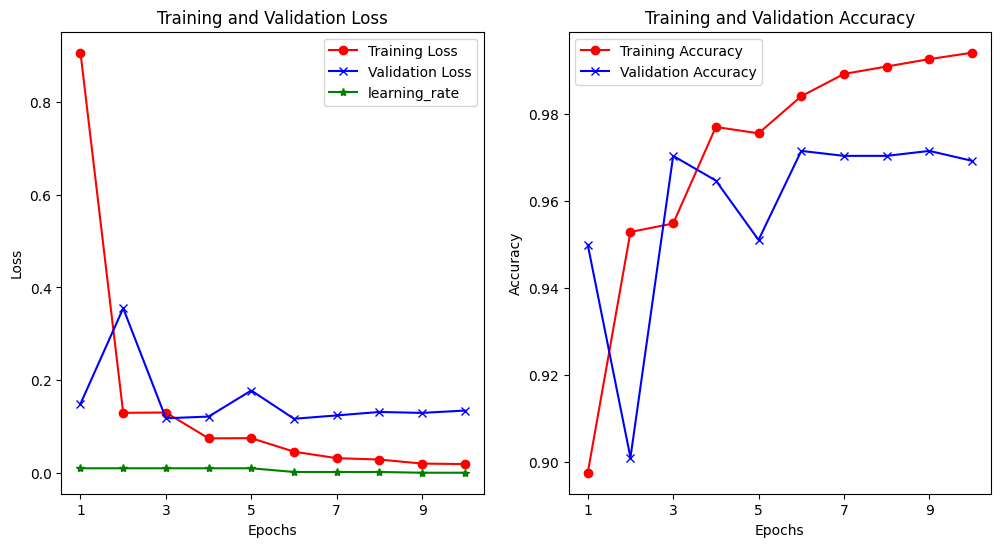

In [ ]:
plot_training_history(history_name=history_4)

In [ ]:
def evaluate(data=None, model=None):
    loss, acc = model.evaluate(data, verbose=2)
    print("Restored model, accuracy: {:5.2f}%".format(100 * acc))
    print("Restored model, loss: {:5.2f}%".format(100 * loss))

In [ ]:
model_4.load_weights(checkpoint_filepath4)
evaluate(val_ds,model_4)

28/28 - 4s - loss: 0.1168 - accuracy: 0.9716 - 4s/epoch - 152ms/step
Restored model, accuracy: 97.16%
Restored model, loss: 11.68%


In [ ]:
evaluate(train_ds,model_4)

129/129 - 20s - loss: 0.0278 - accuracy: 0.9907 - 20s/epoch - 154ms/step
Restored model, accuracy: 99.07%
Restored model, loss:  2.78%


In [ ]:
evaluate(test_ds,model_4)

28/28 - 10s - loss: 0.0949 - accuracy: 0.9715 - 10s/epoch - 348ms/step
Restored model, accuracy: 97.15%
Restored model, loss:  9.49%


In [ ]:
model_4.save('model_4.keras')

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Define function to make prediction
def predict_and_evaluate(model, dataset):
    y_true = []
    y_pred = []

    #  Iterate through the dataset to get the actual label and result prediction
    for image, label in dataset:
        predictions = model.predict(image,verbose=0)
        y_true.extend(label.numpy())
        y_pred.extend(np.round(predictions).flatten())

   # classification report
    report = classification_report(y_true, y_pred, target_names=['normal', 'pneumonia'])

    return report

In [ ]:
def calculate_confusion_matrix(model, dataset):
    y_true = []  # Label yang sebenarnya
    y_pred = []  # Label hasil prediksi


    for image, label in dataset:
        predictions = model.predict(image,verbose=0)
        y_true.extend(label.numpy())
        y_pred.extend(np.round(predictions).flatten())

    #  confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    #Plot confusion_matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Normal', 'Pneumonia'],
                yticklabels=['Normal', 'Pneumonia'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


    tn, fp, fn, tp = conf_matrix.ravel()
    #tp = conf_matrix[1, 1]
    #p = conf_matrix[0, 1]
    #tn = conf_matrix[0, 0]
    #fn = conf_matrix[1, 0]

    return tp, fp, tn, fn

In [ ]:
#Load model
loaded_model_4 = tf.keras.models.load_model('model_4.keras')
classification_report_result = predict_and_evaluate(loaded_model_4, test_ds)
#  classification report
print(classification_report_result)

              precision    recall  f1-score   support

      normal       0.95      0.94      0.95       237
   pneumonia       0.98      0.98      0.98       641

    accuracy                           0.97       878
   macro avg       0.97      0.96      0.96       878
weighted avg       0.97      0.97      0.97       878



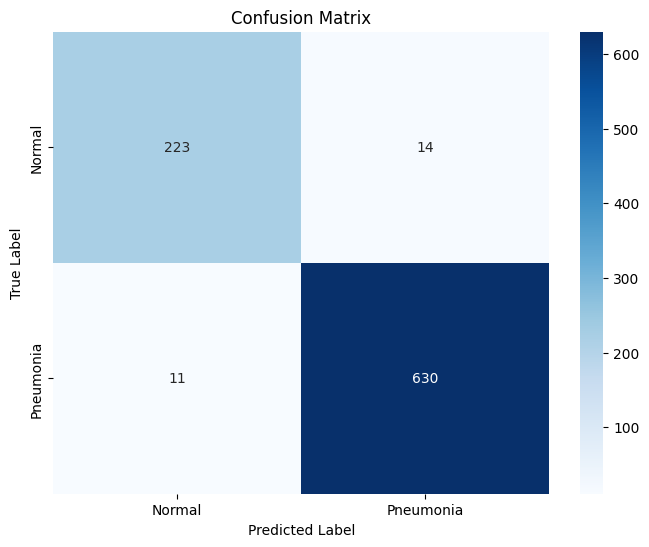

True Positive (TP): 630
False Positive (FP): 14
True Negative (TN): 223
False Negative (FN): 11


In [ ]:
# Increasing confusion matrix by model loading and dataset testing
tp, fp, tn, fn = calculate_confusion_matrix(loaded_model_4, test_ds)
print("True Positive (TP):", tp)
print("False Positive (FP):", fp)
print("True Negative (TN):", tn)
print("False Negative (FN):", fn)